In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Precipitation Analysis

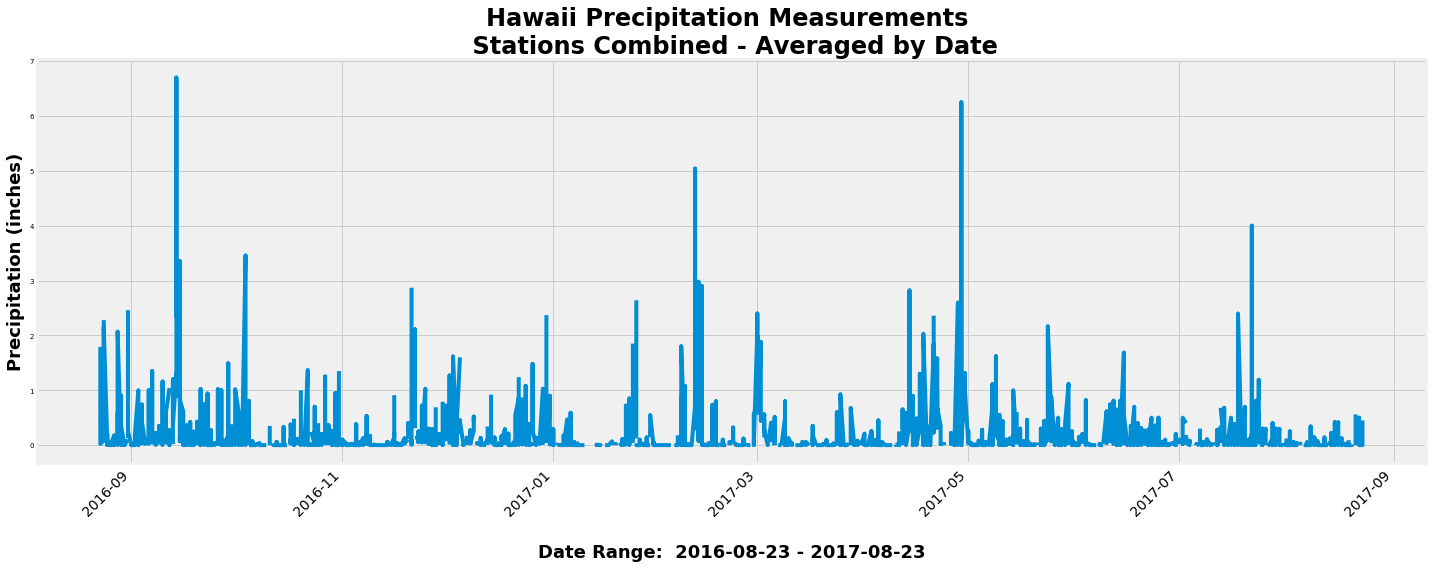

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precip_df = pd.read_sql("SELECT date, prcp FROM Measurement", con=engine, columns=[['date'],['prcp']])

# Convert date variable to date.time for Pandas
precip_df['date'] = pd.to_datetime(precip_df['date'],format="%Y-%m-%d", errors="coerce")

# Calculate the date 1 year ago from the last data point in the database
max_date = precip_df['date'].max().date()
min_date = (max_date - dt.timedelta(days=365))

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = precip_df.loc[precip_df['date']>=str(min_date)]
precip_df.set_index('date', inplace=True)

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

precip_df.plot(use_index=True, y='prcp', figsize=(20,8))
plt.gcf().subplots_adjust(bottom=0.15)
plt.title("Hawaii Precipitation Measurements \n Stations Combined - Averaged by Date", fontweight='bold',size=24)
plt.xlabel(f"\nDate Range:  {min_date} - {max_date}", fontweight='bold', size=18)
plt.ylabel("Precipitation (inches)", fontweight='bold', size=18)
plt.yticks(size=7)
plt.xticks(rotation=45, size=14)
#plt.legend(["precipitation"],loc=1, fontsize='small', bbox_to_anchor=(.90, 1))
plt.legend().set_visible(False)
plt.tight_layout()
plt.savefig('precipitation_amounts.png')
plt.show()


In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe(include='all')


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [10]:
# Design a query to show how many stations are available in this dataset
num_stations = session.query(Measurement.station).distinct(Measurement.station).count()
print(f"There are {num_stations} stations in the dataset")

There are 9 stations in the dataset


In [11]:
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station,
                  func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc())
for row in station_activity:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
highest_station_activity = session.query(Measurement.station,
                  func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).limit(1).scalar()
print(f"The station with the hightest number of observations is {highest_station_activity}. ")

The station with the hightest number of observations is USC00519281. 


# Temperature Analysis

In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

q = session.query(Station.id,
                  Station.name,
                  func.min(Measurement.tobs),
                  func.max(Measurement.tobs),
                  func.avg(Measurement.tobs))\
.filter(Measurement.station == Station.station)\
.filter(Measurement.station == highest_station_activity)
avg_tmp_rec = "{0:.1f}".format(q[0][4])
print(f"Most Active Station ID: {q[0][0]}, \
    Name: {highest_station_activity},\
    Location: {q[0][1]} \nResults: \n    Minimum temperature recorded:  {q[0][2]}\n\
    Maximum temperture recorded :  {q[0][3]}\n    Average temperature recorded:  {avg_tmp_rec}")

Most Active Station ID: 7,     Name: USC00519281,    Location: WAIHEE 837.5, HI US 
Results: 
    Minimum temperature recorded:  54.0
    Maximum temperture recorded :  85.0
    Average temperature recorded:  71.7


In [14]:
tobs_twelve = session.query(Measurement.tobs)\
    .filter(Measurement.date > min_date)\
    .filter(Measurement.station == highest_station_activity)\
    .order_by(Measurement.tobs).all()

tobs_df = pd.DataFrame(tobs_twelve, columns=['temp'])
tobs_df.head()

,temp
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


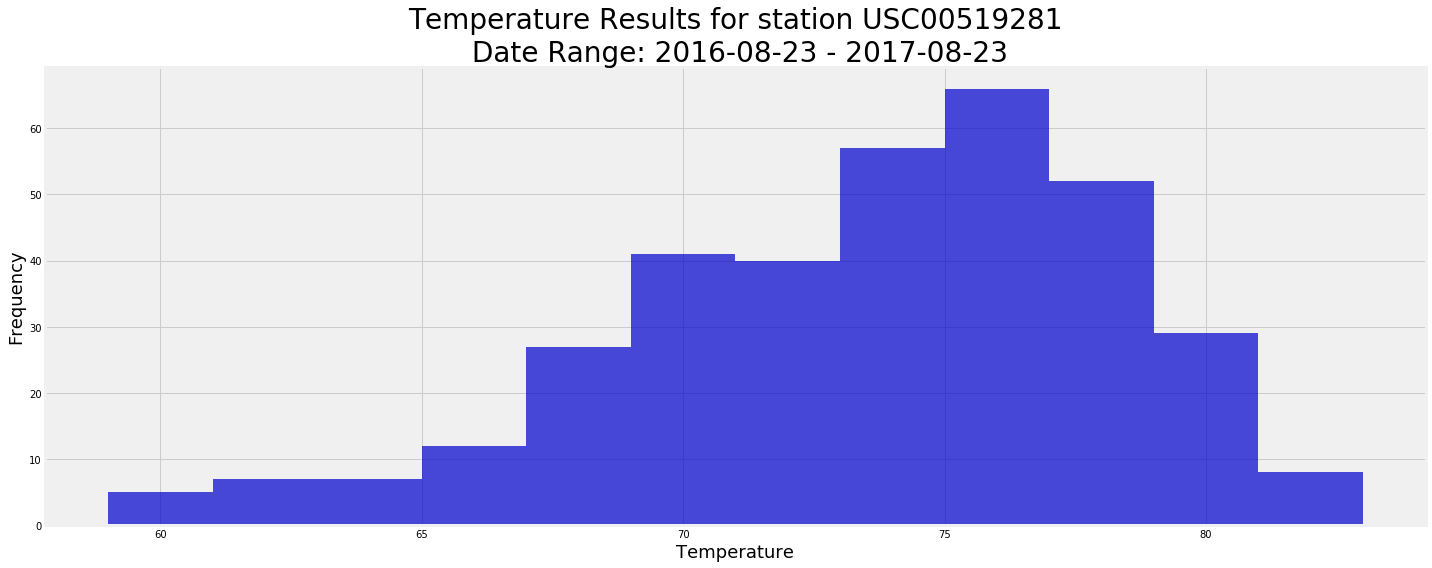

In [15]:
# Plot Temperature Results for Most Active Station
plt.subplots(figsize=(20,8))

plt.hist(tobs_df['temp'], bins=12, color="mediumblue", alpha=.7)
plt.title(f"Temperature Results for station {highest_station_activity}\n Date Range: \
{min_date} - {max_date}",fontsize=28)
plt.xlabel('Temperature', fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.savefig('temperature_results_hist.png')
plt.show()

The minimum temperature for your date range is: 62.0
The maximum temperature for your date range is: 74.0
The average temperature for your date range is: 69.57142857142857


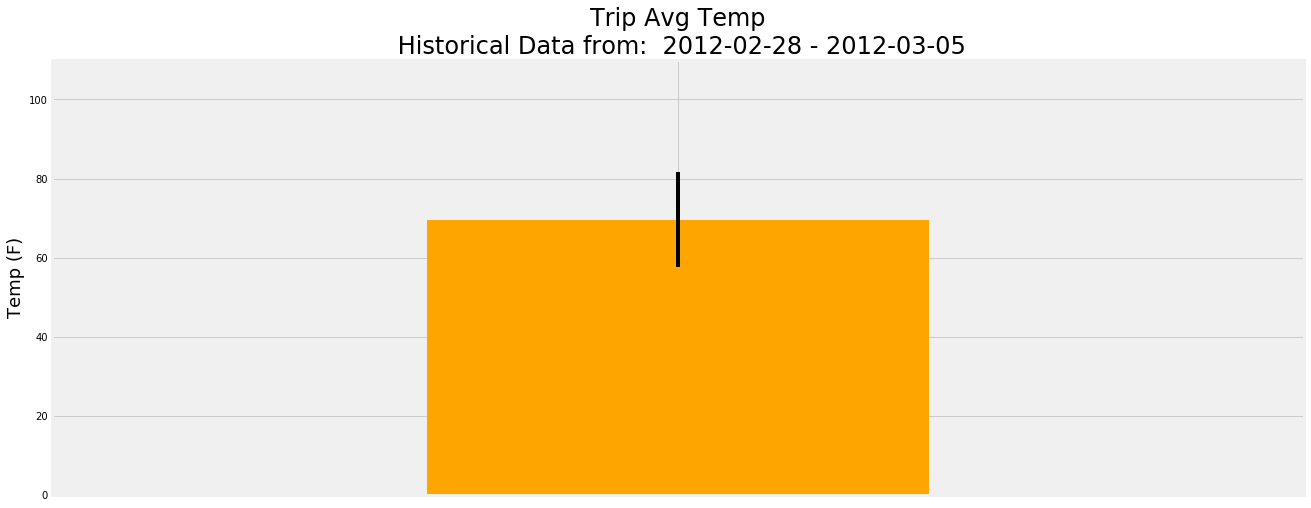

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates -- this has been modified 
#to run the analysis and generate graph as part of function

def calc_temps(start, end):
    query = session.query(Measurement.tobs).filter(Measurement.date>=start, Measurement.date<=end).all()
    temperatures = [temp[0] for temp in query]
    avg_temp = np.mean(temperatures)
    lowest_temp = min(temperatures)
    highest_temp = max(temperatures)
    
    print(f"The minimum temperature for your date range is: {lowest_temp}")
    print(f"The maximum temperature for your date range is: {highest_temp}")
    print(f"The average temperature for your date range is: {avg_temp}")
    
    
    plt.subplots(figsize=(20,8))
    plt.xlim(0, 2)
    plt.ylim([0,110])
    plt.bar(1, avg_temp, color = 'orange', yerr = (highest_temp-lowest_temp), tick_label="", align='center')
    plt.title(f"Trip Avg Temp\n Historical Data from:  {start} - {end}", fontsize=24)
    plt.ylabel("Temp (F)", fontsize = 18)
    plt.savefig('trip_ave_temp.png')
    
    
output = calc_temps('2012-02-28', '2012-03-05')





The minimum temperature for your date range is: 58.0
The maximum temperature for your date range is: 87.0
The average temperature for your date range is: 74.14387974230493


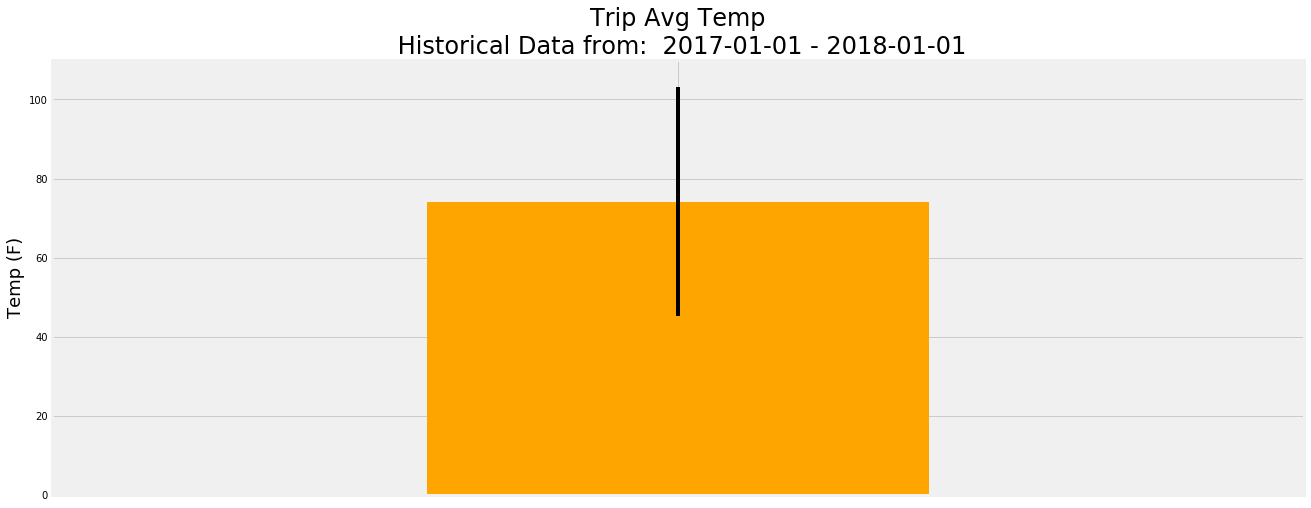

In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

calc_temps('2017-01-01', '2018-01-01')




In [29]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
q = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= '2017-01-01')\
.filter(Measurement.date <= '2018-01-01')\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

# A nice layout to read the results
print()
print (f"Historical Rainfall Per Weather Station - Descending order\n  Trip Dates: \
{'2017-01-01'} - {'2018-01-01'}\n  Most Recent Data Search Dates: {'2017-01-01'} - {'2018-01-01'}")
print()
for row in q:
    rain="{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print()       



Historical Rainfall Per Weather Station - Descending order
  Trip Dates: 2017-01-01 - 2018-01-01
  Most Recent Data Search Dates: 2017-01-01 - 2018-01-01

Station:  USC00516128
    Rainfall:  68.78  
    Location:  MANOA LYON ARBO 785.2, HI US
    Elevation:  152.4      Latitude:  21.3331  Longitude:  -157.8025

Station:  USC00519281
    Rainfall:  43.66  
    Location:  WAIHEE 837.5, HI US
    Elevation:  32.9      Latitude:  21.45167  Longitude:  -157.84888999999998

Station:  USC00513117
    Rainfall:  34.62  
    Location:  KANEOHE 838.1, HI US
    Elevation:  14.6      Latitude:  21.4234  Longitude:  -157.8015

Station:  USC00519523
    Rainfall:  27.32  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5      Latitude:  21.33556  Longitude:  -157.71139

Station:  USC00514830
    Rainfall:  21.80  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00519397
    Rainfall:  10.66